### Imports

In [1]:
!nvidia-smi

Thu Jun 27 20:58:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A2                      On  |   00000000:98:00.0 Off |                    0 |
|  0%   30C    P8              7W /   60W |       0MiB /  15356MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [50]:
import warnings
warnings.filterwarnings('ignore')

import gc

In [3]:
import numpy as np
import pandas as pd
import geopandas
import time, pickle
import torch
from torch.utils.data import DataLoader
import wandb

In [4]:
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *

In [5]:
from elbo import ApproximatePosterior
from gp_mlp import forward_backward_pass, MapDataset, MultipleOptimizer, UpperIndusGridDataset, UpperIndusDataset, prepare_data

/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  / np.math.factorial(order)
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a de

In [6]:
import torch.nn as nn
from stheno.torch import B, GP, EQ, Normal, Measure, Matern12, Matern32, Matern52

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

In [8]:
# Let all of Stheno run on that device.
B.on_device(device).__enter__();

In [9]:
# Dates
start="1900-01-01"
end="2020-12-31"

In [10]:
experiment_region = 'alps_occurrence' # 'alps' or 'langtang'

In [11]:
if experiment_region == 'alps':
    TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF_reduced.pkl'
    TEST_PATH = r'/users/marron31/data/idaweb/maps_for_predictions/1991-06-03.csv'

if experiment_region == 'langtang':
    TRAIN_PATH = '../../data/norris/enriched_obs/enriched_langtang_obs_norris_ready.pkl'

if experiment_region == 'alps_2000':
    TRAIN_PATH = 'alps_2000.pkl'
    TEST_PATH = r'/users/marron31/data/idaweb/maps_for_predictions/1991-06-03.csv'
    
if experiment_region == 'alps_2000s':    
    TRAIN_PATH = 'alps_2000s.pkl'
    TEST_PATH = r'/users/marron31/data/idaweb/maps_for_predictions/1991-06-03.csv'
    
if experiment_region == 'langtang_occurrence':
    TRAIN_PATH = '../../data/norris/enriched_obs/enriched_langtang_obs_norris_ready_occurrence.pkl'
    
if experiment_region == 'alps_occurrence':
    TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF_reduced_occurrence.pkl'
    TEST_PATH = r'/users/marron31/data/idaweb/maps_for_predictions/1991-06-03.csv'

In [12]:
predictant = ['Prec']

if 'alps' in experiment_region:
    predictors = [
                  'X','Y',#'Z', 
                  'RAIN',
                  'doy_sin', 'doy_cos', 
                  'W500', 'RH2', 'U500', 'V10', 
                  'RH500', 'U10', 'V500', 
                  'T2MIN', 'T2', 'T2MAX'
                 ]

if 'langtang' in experiment_region:
    predictors = [
                  'X', 'Y', #'Z',
                  'precip_norris',
                  'doy_sin', 'doy_cos', 
                  'w500_norris','RH2_norris','u500_norris','v10_norris',
                  'RH500_norris','u10_norris','v500_norris',
                  'T2min_norris','T2_norris','T2max_norris'
                 ]

In [13]:
# Initially used to create split but then manually setting stations because 
# there is some issue with stations missing after data preparation process
# pick 10% random stations for validation, 10% for testing and the rest for training

# stations = list(pd.read_pickle(TRAIN_PATH).Station.unique())
# random.shuffle(stations)
# val_stations = stations[:int(len(stations)*0.1)]
# test_stations = stations[int(len(stations)*0.1):int(len(stations)*0.2)]
# train_stations = stations[int(len(stations)*0.2):]

In [14]:
if 'alps' in experiment_region:
    train_stations = ['ABO', 'AHO', 'AIR', 'ALV', 'APT', 'ARO', 'AUB', 'AVA', 'AVB', 'BAC', 'BAL', 'BEA', 'BEC', 'BEGTH', 'BEGWA', 'BEH', 'BEHAK', 'BEKSE', 'BERIF', 'BES', 'BEV', 'BIN', 'BIV', 'BLA', 'BRA', 'BRW', 'BSP', 'BSW', 'CAV', 'CDF', 'CHA', 'CHB', 'CHD', 'CHM', 'CHW', 'CIM', 'COV', 'CTA', 'CTO', 'CUE', 'DAV', 'DIB', 'DIS', 'DLBAL', 'DLFEB', 'DLZUG', 'DMA', 'DOL', 'EIT', 'ENG', 'ERN', 'EVL', 'EVO', 'FIL', 'FIO', 'FIT', 'FLI', 'FRE', 'GEN', 'GOA', 'GRC', 'GRH', 'GSB', 'GSG', 'GST', 'GTT', 'GWA', 'HER', 'HIR', 'HOE', 'INF', 'IYDEO', 'IYDEU', 'IYMMR', 'IYMUW', 'IYPEN', 'IYPFE', 'IYPFI', 'IYPLI', 'IYPRU', 'IYREI', 'IYRID', 'IYROT', 'IYSMG', 'IYSMT', 'IYSUL', 'IYSUM', 'IYSVP', 'IYSWA', 'IYTER', 'IYTOB', 'IYULT', 'IYVAA', 'IYVAL', 'IYWEL', 'IYWOL', 'KLA', 'KRO', 'KSE', 'LBA', 'LEH', 'LEU', 'LOC', 'LOE', 'MAL', 'MAT', 'MAU', 'MLS', 'MOD', 'MSO', 'MST', 'MTE', 'MUE', 'MUS', 'MVE', 'NABCHA', 'NABDAV', 'NAP', 'NEB', 'OBI', 'OBW', 'PDM', 'PIG', 'PIL', 'PLF', 'PON', 'PSB', 'PUD', 'REC', 'ROB', 'ROE', 'ROG', 'RUM', 'SAB', 'SAE', 'SAF', 'SAM', 'SAN', 'SAP', 'SAS', 'SBA', 'SBE', 'SCU', 'SDO', 'SED', 'SEP', 'SGD', 'SIA', 'SIM', 'SLFAM2', 'SLFEM2', 'SLFFIS', 'SLFGL2', 'SLFMEI', 'SLFOBM', 'SLFSA3', 'SLFSC2', 'SLFSC3', 'SLFTU2', 'SLFUR2', 'SLFURS', 'SNE', 'SOG', 'SRL', 'STP', 'SVG', 'SWA', 'TIBED', 'TIBIA', 'TICOL', 'TIFUS', 'TIOLI', 'TST', 'UNS', 'URB', 'VDLSP', 'VDSEP', 'VEL', 'VIO', 'VRI', 'VSANZ', 'VSARO', 'VSBRI', 'VSCHY', 'VSDUR', 'VSEMO', 'VSFIN', 'VSGDX', 'VSJEI', 'VSMAT', 'VSSAB', 'VSSTA', 'VST', 'VSVER', 'WAW', 'WET', 'ZER', 'ZEV', 'ZNZ']
    val_stations = ['ANT', 'BEHAB', 'BIO', 'BOS', 'BRL', 'BUF', 'ELO', 'FIE', 'GRY', 'GUE', 'IYHIN', 'IYTAU', 'KAS', 'LAT', 'LBG', 'MEB', 'RIE', 'SLFSH2', 'SLFSP2', 'SMM', 'SMZ', 'TICVM', 'VAB', 'VSMOI', 'VSTSN']
    len(train_stations), len(val_stations)

In [15]:
if 'langtang' in experiment_region:
    stations = ['Tipping Bucket Lama Hotel', 
                  'Tipping Bucket Langtang',
                  'Tipping Bucket Kyanjing', 
#                 'Tipping Bucket Numthang old',
#                 'Tipping Bucket Jathang', 
#                 'Pluviometer Yala', 
#                 'AWS Kyangjing',
#                 'AWS Yala BC', 
                  'Tipping Bucket Ganja La 3',
                  'Tipping Bucket Ganja La 2',
                  'Tipping Bucket Langshisha Glacier (next to Pluviometer)',
                  'Tipping Bucket Ganja La 1',
                  'Tipping Bucket Langshisha BC',
                  'Tipping Bucket Shalbachum',
#                 'Pluviometer Langshisha Glacier (off-glacier)',
                  'Pluviometer GanjaLa', 
                  'Pluviometer Morimoto'
                 ]

    train_stations = stations[:7]
    val_stations = stations[7:]

### Dataloaders

In [16]:
ds_dataset = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=train_stations)
ds_dataset_val = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=val_stations)

train_mean = ds_dataset.mean
train_var = ds_dataset.var

In [156]:
train_dataloader = DataLoader(dataset=ds_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(dataset=ds_dataset_val, batch_size=16*2, shuffle=True)

In [114]:
# ds_dataset_test = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=test_stations)
# ds_dataset_map = UpperIndusDataset(TEST_PATH, start, end, predictant, predictors, stations=test_stations)
# dataloader_test = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)

if 'alps' in experiment_region:
    ds_dataset_map = MapDataset(TEST_PATH, predictors, train_mean, train_var)
    dataloader_map = DataLoader(dataset=ds_dataset_map, batch_size=1, shuffle=False)

# Models

In [19]:
num_GP_dims = 2

In [20]:
drop_GP_dims = True

if drop_GP_dims:
    in_channels = len(predictors) + 1 - num_GP_dims
else:
    in_channels = len(predictors) + 1

In [21]:
if 'occurrence' in experiment_region:
    likelihood_fn='bernoulli'
else:
    likelihood_fn='bgmm'

In [124]:
del model

In [125]:
# This is the MLP used in the GP-MLP model
model = MLP(in_channels=in_channels, 
            hidden_channels=[50,50], 
            likelihood_fn=likelihood_fn, # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
model.to(device);

Number of parameters: 3351


In [126]:
baseline = False

# This is the MLP used as a baseline (on its own)
if baseline:
    MLP = MLP(in_channels= len(predictors), 
                hidden_channels=[50,50], 
                likelihood_fn=likelihood_fn, # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
                dropout_rate=0,
               )

    print(f'Number of parameters: {sum(p.numel() for p in MLP.parameters())}')
    MLP.to(device);

In [127]:
def reset_weights(m):
    '''
    This function resets model weights randomly following the original initialization method.
    Works for simple architectures and commonly used layers.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # If the layer has the method `reset_parameters`, it will be called
            layer.reset_parameters()

### MLP (baseline)

In [157]:
log_on_wandb = False

In [158]:
if log_on_wandb:
    wandb.init(project=f'GP-MLP-{experiment_region}',
               name='MLP-50-50'
               )

In [159]:
if baseline:
    MLP.apply(reset_weights);

In [160]:
if baseline:
    train_losses = []
    val_losses = []
    test_losses = []

    train_loader = train_dataloader
    valid_loader = val_dataloader
    # test_loader = dataloader

    epochs = 15

    mlp_optimizer = torch.optim.Adam(MLP.parameters(), lr=0.005)

    for epoch in range(epochs):

        epoch_train_losses, epoch_val_losses = [], []

        MLP.train()

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.float().to(device) # [batch_size, num_stations, num_predictiors]
            labels = labels.float().to(device) # [batch_size, num_stations]

            inputs = inputs.permute([0,2,1])
            batch_size = inputs.shape[0]

            mlp_optimizer.zero_grad()

            outputs = MLP(inputs)

            loss = loss_fn(outputs, labels, inputs, MLP, reduction='sum', device=device)/batch_size 

            # print('train: ', epoch, i, loss.item())

            if loss.item() != 0: 

                loss.backward()

                for param in mlp_optimizer.param_groups[0]['params']:
                    nn.utils.clip_grad_value_(param, 1) # Bit of regularisation

                mlp_optimizer.step()

            epoch_train_losses.append(loss.item())

            #train_loss, val_loss, test_loss = train_epoch(MLP, optimizer, train_loader, valid_loader, test_loader=test_loader, print_progress=True, epoch=epoch, device=device, permute=True)

        model.eval()

        with torch.no_grad():

            for i, (inputs, labels) in enumerate(val_dataloader):

                inputs = inputs.float().to(device) # [batch_size, num_stations, num_predictiors]
                labels = labels.float().to(device) # [batch_size, num_stations]

                inputs = inputs.permute([0,2,1])
                batch_size = inputs.shape[0]

                outputs = MLP(inputs)

                loss = loss_fn(outputs, labels, inputs, MLP, reduction='sum', device=device) / batch_size

                epoch_val_losses.append(loss.item())

        epoch_train_loss = np.mean(epoch_train_losses)/len(train_stations) 
        epoch_val_loss = np.mean(epoch_val_losses)/len(val_stations) #, np.mean(test_losses)

        print(f'epoch : {epoch+1}, train loss : {np.mean(epoch_train_loss):.4f} , valid loss : {np.mean(epoch_val_loss):.4f}')

        if log_on_wandb:
            wandb.log({"train_loss": epoch_train_loss,  
                       "val_loss": epoch_val_loss,
                       "epoch" : epoch,
                          })


        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
    #     test_losses.append(test_loss)

In [161]:
if baseline:
    plt.plot(np.array(train_losses), label='train')
    plt.plot(np.array(val_losses), label='val')
    plt.title(f"best val loss: {min(val_losses):.4f}")
    plt.legend()
    plt.show()

### GP-MLP

#### Diagonal jitter (depending on dataset)

In [162]:
# B.epsilon is the default value for the diagonal jitter of the matrix
# Needs to be relatively high for `float32`s

if 'langtang' in experiment_region:
    B.epsilon = 1e-6
elif 'alps' in experiment_region:
    B.epsilon = 1e-5
    
print(B.epsilon)

1e-05


In [163]:
model.apply(reset_weights);

In [164]:
print_progress = True
validate_flag = True
f_marginal_flag = False
mc_samples = 10

In [165]:
experiment_name = 'MLP-50-50_matern_ls_ind_2D_lr10-4'

In [166]:
log_on_wandb = False

if log_on_wandb:
    wandb.init(project=f'GP-MLP-{experiment_region}',
               name=experiment_name,
               )

In [167]:
st = ds_dataset.st
st_val = ds_dataset_val.st

coords_train_stations = st.groupby('Station').mean()[predictors[:num_GP_dims]].values
coords_val_stations = st_val.groupby('Station').mean()[predictors[:num_GP_dims]].values

x_ind_stations = coords_train_stations
x_val_statins = coords_val_stations

In [168]:
# Inducing points are points in the station locations
# x_ind = torch.tensor(x_ind_stations, dtype=torch.float32).detach().requires_grad_(False).to(device)
x_ind = torch.nn.Parameter(torch.tensor(x_ind_stations, dtype=torch.float32, requires_grad=True).to(device))
num_ind_points = len(x_ind)

n = len(st)

log_ls = torch.nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32, requires_grad=True).to(device))
    
q = ApproximatePosterior(num_ind_points) # q is the approximate posterior

# optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters()), lr=10e-4)
optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters())+[log_ls], lr=10e-3)
# optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters())+[log_ls]+[x_ind], lr=10e-5)

In [169]:
load_model = False
exp_name = 'matern_ls'

# Options for loading an existing model, otherwise start from scratch

if load_model:
    q.load_state_dict(torch.load(f'q_state_{exp_name}.pth'))
    optimizer.load_state_dict(torch.load(f'optimizer_state_{exp_name}.pth'))
    model.load_state_dict(torch.load(f'model_state_{exp_name}.pth'))

    # Load the data back
    with open(f'training_progress_{exp_name}.pkl', 'rb') as file:
        data_loaded = pickle.load(file)

    e_past = data_loaded["last_epoch"]
    train_loss = data_loaded["train_loss"]
    train_loglik = data_loaded["train_loglik"]
    train_kl = data_loaded["train_kl"]
    train_nll = data_loaded["train_nll"]
    val_loss = data_loaded["val_loss"]
    val_loglik = data_loaded["val_loglik"]
    val_kl = data_loaded["val_kl"]
    val_nll = data_loaded["val_nll"]

else:
    e_past = 0
    train_loss, train_loglik, train_kl, train_nll = [], [], [], []
    val_loss, val_loglik, val_kl, val_nll = [], [], [], []

test_loss, test_loglik, test_kl, test_nll  = [], [], [], []

train_loss_batch, train_loglik_batch, train_kl_batch, train_nll_batch = RunningAverage(), RunningAverage(), RunningAverage(), RunningAverage()
val_loss_batch, val_loglik_batch, val_kl_batch, val_nll_batch = RunningAverage(), RunningAverage(), RunningAverage(),RunningAverage()

In [ ]:
num_epochs = 30

# with Measure() as prior:
#     f3 = GP(Matern12().stretch(ls))
#     f = f3 #f1 + f2 + f3
    
for e in range(e_past + 1, num_epochs + 1):
    
    gc.collect()
    
#     print(f"Memory allocated before training epoch: {e}, {torch.cuda.memory_allocated()/(1024**2):.2f}")
#     print(f"Max memory allocated before training epoch: {e}, {torch.cuda.max_memory_allocated()/(1024**2):.2f}")
    
    # TRAIN EPOCH    
    model.train()

    start_time = time.time()

    train_loss_batch.reset()
    train_loglik_batch.reset()
    train_kl_batch.reset()
    train_nll_batch.reset()
    val_loss_batch.reset()
    val_loglik_batch.reset()
    val_kl_batch.reset()
    val_nll_batch.reset()

    n = train_dataloader.dataset.n
    
    for i, (inputs, labels) in enumerate(train_dataloader):

        inputs = inputs.to(device) # inputs [batch_size, num_predictors, num_stations]
        labels = labels.to(device) # labels [batch_size, num_stations]
        
        with Measure() as prior:
            f3 = GP(Matern12().stretch(torch.exp(log_ls)))
            f = f3 #f1 + f2 + f3

        elbo, recon, kl, num_points, nll = forward_backward_pass(inputs, labels, n, model, optimizer, q, f, x_ind, 
                                                            inducing_points=True, backward=True, f_marginal=f_marginal_flag, n_samples=mc_samples,
                                                            num_GP_dims=num_GP_dims, remove_from_inputs=drop_GP_dims)
        
#         print(i, elbo.item(), recon.item(), kl.item(), num_points.item(), nll.item())
#         print(f'GP lengthscale: {ls.item()}')
#         print(torch.stack([torch.isnan(p).sum() for p in model.parameters()]))

        # Keep track of loss terms
        train_loss_batch.update(-elbo.item())
        train_loglik_batch.update(-recon.item()/num_points.item())
        train_kl_batch.update(kl.item())
        train_nll_batch.update(nll.item()/num_points.item())
    
    elapsed = time.time() - start_time

    if print_progress:
        print(f'Train epoch  {e}: -elbo: {train_loss_batch.avg:.3f} | kl: {train_kl_batch.avg:.3f} | -recon: {train_loglik_batch.avg:.3f} | nll: {train_nll_batch.avg:.3f} -- time: {elapsed:.2f}')

    # Add average batch loss terms to lists
    train_loss.append(train_loss_batch.avg)
    train_loglik.append(train_loglik_batch.avg)
    train_kl.append(train_kl_batch.avg)
    train_nll.append(train_nll_batch.avg)
    
    # VALIDATION EPOCH
    validate_flag = True
    if validate_flag:
        
#         print(f"Memory allocated before validation epoch: {e}, {torch.cuda.memory_allocated()/(1024**2):.2f}")
#         print(f"Max memory allocated before validation epoch: {e}, {torch.cuda.max_memory_allocated()/(1024**2):.2f}")

        model.eval()

        n = val_dataloader.dataset.n
        
        start_time = time.time()

        with torch.no_grad():

            for i, (inputs, labels) in enumerate(val_dataloader):        
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                with Measure() as prior:
                    f3 = GP(Matern12().stretch(torch.exp(log_ls)))
                    f = f3 #f1 + f2 + f3

                elbo, recon, kl, num_points, nll = forward_backward_pass(inputs, labels, n, model, optimizer, q, f, x_ind, 
                                                                    inducing_points=True, backward=False, f_marginal=f_marginal_flag, n_samples=mc_samples*100,
                                                                    num_GP_dims=num_GP_dims, remove_from_inputs=drop_GP_dims)

                
                # Keep track of loss terms
                val_loss_batch.update(-elbo.item())
                val_loglik_batch.update(-recon.item()/num_points.item())
                val_kl_batch.update(kl.item())
                val_nll_batch.update(nll.item()/num_points.item())
        
        elapsed_val = time.time() - start_time

        if print_progress:
            print(f'Val epoch {e}: -elbo: {val_loss_batch.avg:.3f} | kl: {val_kl_batch.avg:.3f} | -recon: {val_loglik_batch.avg:.3f} | nll: {val_nll_batch.avg:.3f} -- time: {elapsed_val:.2f}')
            print(f'GP lengthscale: {torch.exp(log_ls).item():.3f}')
            print('---')
            
        if log_on_wandb:
            wandb.log({"train_nelbo": train_loss_batch.avg,  
                       "val_nelbo": val_loss_batch.avg,
                       "train_kl": train_kl_batch.avg,  
                       "val_kl": val_kl_batch.avg,
                       "train_nrecon": train_loglik_batch.avg,  
                       "val_nrecon": val_loglik_batch.avg,
                       "train_nll": train_nll_batch.avg,  
                       "val_nll": val_nll_batch.avg,
                       "epoch" : e,
                       "ls" : torch.exp(log_ls).item(),
                      })

        # Add average batch loss terms to lists
        val_loss.append(val_loss_batch.avg)
        val_loglik.append(val_loglik_batch.avg)
        val_kl.append(val_kl_batch.avg)
        val_nll.append(val_nll_batch.avg)

Train epoch  1: -elbo: 0.770 | kl: 716.339 | -recon: 0.320 | nll: 0.320 -- time: 64.02
Val epoch 1: -elbo: 0.300 | kl: 41.596 | -recon: 0.247 | nll: 0.247 -- time: 52.62
GP lengthscale: 0.046
---
Train epoch  2: -elbo: 0.324 | kl: 34.253 | -recon: 0.302 | nll: 0.302 -- time: 65.00
Val epoch 2: -elbo: 0.279 | kl: 30.046 | -recon: 0.240 | nll: 0.240 -- time: 52.88
GP lengthscale: 0.047
---
Train epoch  3: -elbo: 0.319 | kl: 28.991 | -recon: 0.301 | nll: 0.301 -- time: 66.77
Val epoch 3: -elbo: 0.274 | kl: 27.445 | -recon: 0.239 | nll: 0.239 -- time: 53.32
GP lengthscale: 0.051
---
Train epoch  4: -elbo: 0.315 | kl: 24.656 | -recon: 0.300 | nll: 0.300 -- time: 66.22
Val epoch 4: -elbo: 0.273 | kl: 24.563 | -recon: 0.242 | nll: 0.242 -- time: 53.02
GP lengthscale: 0.059
---
Train epoch  5: -elbo: 0.315 | kl: 24.452 | -recon: 0.299 | nll: 0.299 -- time: 65.73
Val epoch 5: -elbo: 0.269 | kl: 24.185 | -recon: 0.238 | nll: 0.238 -- time: 52.81
GP lengthscale: 0.081
---
Train epoch  6: -elbo: 0

In [79]:
# Save the model and optimizer state

exp_name = experiment_name

torch.save(q.state_dict(), f'q_state_{exp_name}.pth')
torch.save(model.state_dict(), f'model_state_{exp_name}.pth')
torch.save(optimizer.state_dict(), f'optimizer_state_{exp_name}.pth')

data_to_save = {
    "last_epoch": e,
    "train_loss": train_loss,
    "train_loglik": train_loglik,
    "train_kl": train_kl,
    "train_nll": train_nll,
    "val_loss": val_loss,
    "val_loglik": val_loglik,
    "val_kl": val_kl,
    "val_nll": val_nll,
}

# Save the data to a file
with open(f'training_progress_{exp_name}.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

ValueError: zero-size array to reduction operation minimum which has no identity

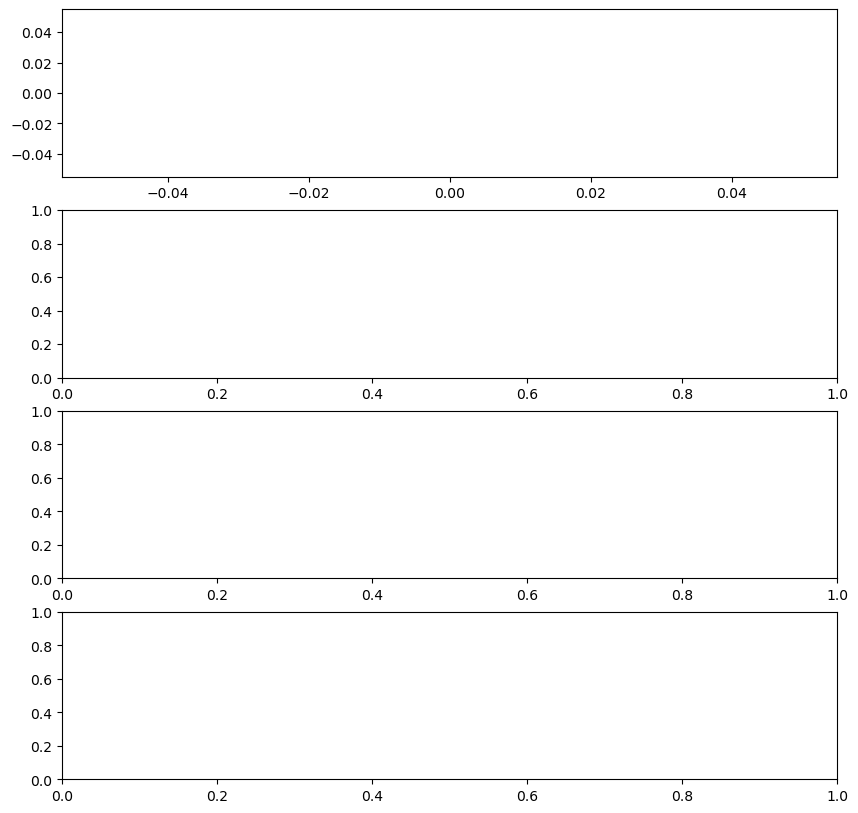

In [80]:
train_vars = [train_loss, train_loglik, train_kl, train_nll] 
validation_vars = [val_loss, val_loglik, val_kl, val_nll]

labels = ['Negative ELBO','Negative log likelihood term','KL divergence term','NLL']

fig, axes = plt.subplots(4,1, figsize=(10,10))
for i,ax in enumerate(axes.flatten()):
    ax.plot(train_vars[i], label='train')
    ax.plot(validation_vars[i], label='val')
    ax.set_title(f'{labels[i]} | best: {np.min(validation_vars[i]):.4f}')
    ax.set_ylabel(f'{labels[i]}', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_xticks(np.arange(0, len(train_vars[i])))
    ax.legend()
#     ax.set_yscale('log')
plt.tight_layout()
plt.show()

### Test maps

In [ ]:
# test_dataloader = DataLoader(dataset=UpperIndusGridDataset(root_folder, train_mean, train_var), batch_size=1, shuffle=True)

inducing_points = True

model.eval()

# n = val_dataloader.dataset.n

with torch.no_grad():

    for i, (inputs, aux_inputs) in enumerate(dataloader_map):
        
        inputs = inputs.permute(0,2,1).to(device)
        og_inputs = inputs.to('cpu')
#         pdb.set_trace()
        inputs, outputs = forward_backward_pass(inputs, None, n, model, optimizer, q, f, x_ind, num_GP_dims=num_GP_dims,
                                                inducing_points=True, backward=False, f_marginal=f_marginal_flag, n_samples=1, 
                                                test_time=True, remove_from_inputs=drop_GP_dims)



In [ ]:
# Build MV Normal Distribution
q.build_normal()

if 'f_samples' in locals():
    del f_samples

for i in range(5):
    f_post = f | (f(x_ind), q.sample())
    x = inputs[:,:,:,1:num_GP_dims+1]
    f_sample = f_post(x).sample()
    if 'f_samples' not in locals():
        f_samples = f_sample
    else:
        f_samples = torch.cat((f_samples, f_sample), dim=0)
    

In [ ]:
f_samples = f_samples.permute(2,1,3,0)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
col_names = ['X','Y','wrf_prcp',
#              'doy_sin','doy_cos',
             'GPsample','pi',#,'alpha','beta',
             'S1','S2','S3','S4','S5']
#col_names = ['X','Y','Z','wrf_prcp','doy_sin','doy_cos','GPsample','alpha','beta']

data = np.concatenate([og_inputs.squeeze().permute(1,0).cpu().numpy()[:,:3],
#                        inputs.squeeze().cpu().numpy()[:,9:10], #* np.sqrt(train_var[9:10]) + train_mean[9:10],
                       np.expand_dims(inputs.squeeze().cpu().numpy()[:,0], axis=1),
                       np.expand_dims(outputs.squeeze().cpu().numpy(), axis=1), # pi
                       f_samples.squeeze().detach().cpu().numpy()] # GP samples
                      , axis=1
                      )

# pdb.set_trace()

df = pd.DataFrame(data, columns=col_names)

df.X = df.X * np.sqrt(train_var[0]) + train_mean[0]
df.Y = df.Y * np.sqrt(train_var[1]) + train_mean[1]

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.X, df.Y))

gdf['uniform'] = gdf.apply(lambda x: np.random.uniform(0,1),axis=1)
#gdf['uniform'] = np.random.uniform(0,1)

gdf['sample'] = gdf.apply(sample_apply, axis=1, likelihood_fn=model.likelihood)

gdf['sample_occurrence'] = gdf['sample'].apply(lambda x: 1 if x > 1 else 0)

# gdf['uniform'] = gdf.apply(lambda x: 0.5, axis=1)
# gdf['bg_median'] = gdf.apply(sample_apply, axis=1)
# gdf['g_mean'] = gdf['alpha']/gdf['beta']

gdf['p'] = 1 - gdf['pi']
gdf['p_binary'] = gdf['sample'].apply(lambda x: 1 if x >= 0.5 else 0)

In [ ]:
st_stations = st.groupby('Station').mean()[['X','Y']] * np.sqrt(train_var[:2]) + train_mean[:2]

In [ ]:
gdf_stations = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x_ind_plot[:,0], x_ind_plot[:,1]))
gdf_val_stations = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x_val_plot[:,0], x_val_plot[:,1]))

plt.figure()
gdf_stations['q_sample'] = q.sample().detach().cpu().numpy()
plt.scatter(x_ind_plot[:,0],x_ind_plot[:,1], label='training locations')
plt.scatter(x_val_plot[:,0],x_val_plot[:,1], label='test locations')
# gdf_stations.plot('q_sample', cmap='viridis')
# gdf_val_stations.plot()
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

# plt.plot(gdf_stations['geometry'].x, gdf_stations['q_sample'], 'o')

In [ ]:
variables = ['wrf_prcp',
             'p_binary',
#              'g_mean',
#              'bg_median',
#              'Z',
             'sample',
             'GPsample',
             'S1','S2','S3','S4','S5',
            ]

labels = ['RCM simulated precip. (mm/day)', 
          'GP-MLP probability of precip. occurrence',
#           '(c) GP-MLP Gamma mean precip. (mm/day)',
#           '(d) GP-MLP median precip. (mm/day)',
#           'Elevation (m.a.s.l.)',
          'Sample from GP-MLP outputs (mm/day)', 
          'GP sample', 'S1','S2','S3','S4','S5',
         ]

cmaps = ['terrain',
         'viridis',
         'terrain',
         'terrain',
         'terrain',
         'terrain',
         'terrain',
         'terrain',
         'terrain',
        ]

fig, axes = plt.subplots(3,3, figsize=(20,20))

for idx, ax in enumerate(axes.flatten()):
    
    if idx < len(variables):
    
    #     gdf.set_crs(catchments.crs)
    #     gdf_clip = geopandas.clip(gdf, catchments)
    
        gdf.plot(variables[idx], ax=ax, markersize=5, marker='.', legend=True, cmap=cmaps[idx], legend_kwds={'shrink': 0.6},)
#         beas.plot(ax=ax, facecolor='None', edgecolor='black')
        #gdf_stations.plot(ax=ax, color='red')
        #sutlej.plot(ax=ax, facecolor='None', edgecolor='black')

        ax.set_title(labels[idx],fontsize=15)
        
#         if variables[idx]=='GPsample':
#             ax.scatter(x_ind_plot[:,0],x_ind_plot[:,1], s=4, c='r')
#             ax.scatter(st_stations['X'],st_stations['Y'], s=3, c='w')

    ax.set_frame_on(False)
    ax.set_yticks([])
    ax.set_xticks([])     

plt.tight_layout()
# plt.savefig('maps2',dpi=300)